# Link Prediction Using DeepSnap and Neural Network

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/COSC4235_Research_Thesis/SocialNetworkAnalysis/Implementation/Datasets'
%ls

/content/drive/MyDrive/COSC4235_Research_Thesis/SocialNetworkAnalysis/Implementation/Datasets
 CiteSeer-ac-loss.pdf   Cora-sp.pdf            PubMed-f1-loss.pdf
 CiteSeer-ac.pdf        Datasets/              PubMed-f1.pdf
 CiteSeer-f1-loss.pdf  'Dolphin- Degree.pdf'   PubMed-pc-loss.pdf
 CiteSeer-f1.pdf       'Dolphin- Degree.png'   PubMed-pc.pdf
 CiteSeer-pc-loss.pdf   dolphins.gml           PubMed-rc-loss.pdf
 CiteSeer-pc.pdf        dolphins.txt           PubMed-rc.pdf
 CiteSeer-rc-loss.pdf  'Email- Degree.pdf'     PubMed-ro-loss.pdf
 CiteSeer-rc.pdf       'Email- Degree.png'     PubMed-ro.pdf
 CiteSeer-ro-loss.pdf   email.txt              PubMed-sp-loss.pdf
 CiteSeer-ro.pdf        Facebook-ac-loss.pdf   PubMed-sp.pdf
 CiteSeer-sp-loss.pdf   Facebook-ac.pdf        raw/
 CiteSeer-sp.pdf        Facebook-f1-loss.pdf   soc-karate.mtx
 Cora-ac-loss.pdf       Facebook-f1.pdf        tmp/
 Cora-ac.pdf            Facebook-pc-loss.pdf   USAir97.net.txt
 Cora-f1-loss.pdf       Facebook-pc.pdf   

In [ ]:
import os
if 'IS_DEEPSNAP_ENV' not in os.environ:
  !pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
  !pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
  !pip install torch-geometric
  !pip install -q git+https://github.com/snap-stanford/deepsnap.git

Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu113.html
     |████████████████████████████████| 7.9 MB 5.7 MB/s 
Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu113.html
     |████████████████████████████████| 3.5 MB 5.0 MB/s 
     |████████████████████████████████| 407 kB 5.5 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.4-py3-none-any.whl size=616603 sha256=22c70dcbaf01d490d6ab442dac62a66d183e06bf407c200901f8856065da5446
  Stored in directory: /root/.cache/pip/wheels/18/a6/a4/ca18c3051fcead866fe7b85700ee2240d883562a1bc70ce421
Successfully built torch-geometric


In [ ]:
import torch
import warnings
import networkx as nx
import matplotlib.pyplot as plt

from pylab import *
from copy import deepcopy
from deepsnap.graph import Graph
from deepsnap.batch import Batch
from deepsnap.dataset import GraphDataset
from torch.utils.data import DataLoader

# Disable DeepSNAP warnings for clearer printout in the tutorial
warnings.filterwarnings("ignore")

Links are seperated into two types: Message passing and supervising links. Message passing are used to make the GNN (used for making node embeddings) and supervision links are used for loss propagation in backwords propagation 


For supervision links, we can use negative sampling (links that do not already exist in the original graph)

Deep snap will create these links automatically and label them 1 if they are positive samplings (i.e they already exist) and 0 if negative samplings 

if the nodes already have a label, they will be shifted by 1 (add 1 to the labels) the negative sampling label will be 0

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

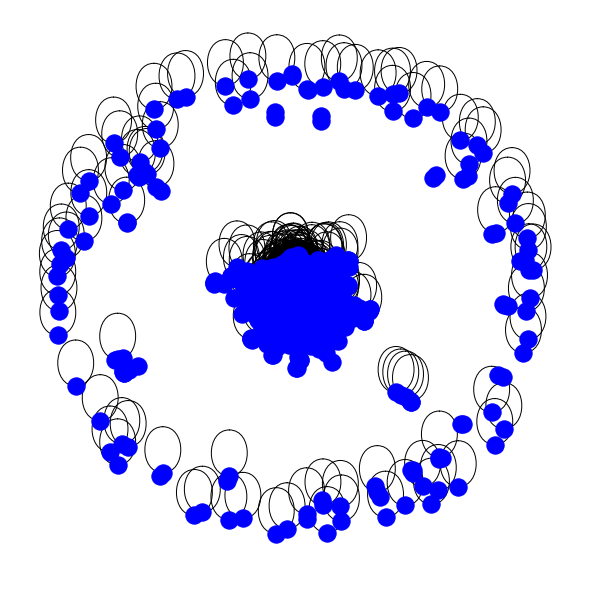

In [ ]:

Yeast_G = nx.read_pajek("Yeast.paj")
Yeast_G = nx.convert_node_labels_to_integers(Yeast_G)

print(Yeast_G.nodes)
print("The graph has {} nodes and {} edges".format(Yeast_G.number_of_nodes(), Yeast_G.number_of_edges()))

pos = nx.spring_layout(Yeast_G, seed=1)
plt.figure(figsize=(8, 8))
nx.draw(Yeast_G, pos=pos, cmap=plt.get_cmap('coolwarm'), node_color="blue", connectionstyle='arc3, rad = 0.01')
plt.show()


There are two possible modes of selecting the supervision edges. All edges are included in the supervision edges 


* At training time: the training supervision edges are same as the training message passing edges.
* At validation time: the message passing edges are the training message passing edges and training supervision edges (still the training message passing edges in this case). The validation supervision edges are disjoint with training supervision edges.
* At test time: the message passing edges are the union of training message passing edges, training supervision edges, and validation supervision edges. The test supervision edges are disjoint with training supervision edges and validation supervision edges.

In general, in all edges mode, the supervision node and the message passing nodes are the same, and the supervision node is all the nodes 


When disjoint mode is selected, the message passing edges are different from supervising edges 

* At training time: the training supervision edges are disjoint with the training message passing edges.
* At validation time: the message passing edges are the union of training message passing edges and training supervision edges. Notice that the validation supervision edges are disjoint with training supervision edges.
* At test time: the message passing edges are the training message passing edges, training supervision edges, and validation supervision edges. The test supervision edges are disjoint with training supervision edges and validation supervision edges.

In [ ]:
import copy
import torch
import torch.nn as nn
import networkx as nx
import torch.nn.functional as F
import matplotlib.pyplot as plt

from deepsnap.graph import Graph
from deepsnap.batch import Batch
from deepsnap.dataset import GraphDataset
from torch_geometric.datasets import Planetoid, TUDataset, FacebookPagePage

from torch.utils.data import DataLoader
from torch_geometric.nn import SAGEConv


from torch_geometric.nn import TAGConv
from torch_geometric.nn import TopKPooling


from torch_geometric.utils import from_networkx, to_networkx

from sklearn.metrics import precision_score #Precision (PC)
from sklearn.metrics import recall_score #Recall (RC)
from sklearn.metrics import f1_score #F1-score (F1), 
from sklearn.metrics import accuracy_score #Accuracy (AC)

from sklearn.metrics import precision_recall_fscore_support #Support (SP)

# Support (SP), what is this? calclate true false positve
#number of occurances in each class


from sklearn.metrics import roc_auc_score # Area Under the Receiver Operating Characteristic Curve (RO)



In [ ]:
from IPython.core.debugger import set_trace #used for debugging

In [ ]:
from torch_geometric.nn import SAGEConv, GCNConv, GATConv, GATv2Conv


In [ ]:
precision_recall_fscore_support([1,1,1,0,0,1,1,1], [1,1,0,0,1,1,1,1])[3]

array([2, 6])

In [ ]:
class LinkPredModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LinkPredModel, self).__init__()

        self.conv1 = GATv2Conv(input_size, hidden_size)
        self.conv2 = GATv2Conv(hidden_size, hidden_size)
        self.conv3 = GATv2Conv(hidden_size, hidden_size)
        self.conv4 = GATv2Conv(hidden_size, hidden_size)

        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.bn2 = nn.BatchNorm1d(hidden_size)
        self.bn3 = nn.BatchNorm1d(hidden_size)


        self.loss_fn = torch.nn.BCEWithLogitsLoss() #lossfunction


    def forward(self, batch):
        x, edge_index, edge_label_index = batch.node_feature, batch.edge_index, batch.edge_label_index

        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.leaky_relu(x)
        x = F.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.leaky_relu(x)
        x = self.conv3(x, edge_index)
        x = self.bn3(x)

        nodes_first = torch.index_select(x, 0, edge_label_index[0,:].long())   #get the first matrix, all of the rows

        nodes_second = torch.index_select(x, 0, edge_label_index[1,:].long())  #second matrix all rows 
        pred = torch.sum(nodes_first * nodes_second, dim=-1)  #multiply the n x n vector and flatten it
        return pred
    
    def loss(self, pred, label): 
        return self.loss_fn(pred, label) #here is where the loss function is difined, it can be changed

In [ ]:
def train(model, dataloaders, optimizer, args):
    val_max = 0
    best_model = model

    train_acc, test_acc, train_loss = [],[],[]
    for epoch in range(1, args["epochs"]):
        for i, batch in enumerate(dataloaders['train']):
            accumulative_loss = 0 #accumulative loss counter 
            
            batch.to(args["device"])
            model.train()
            optimizer.zero_grad()
            pred = model(batch)
            loss = model.loss(pred, batch.edge_label.type(pred.dtype))
            loss.backward()
            optimizer.step()
            accumulative_loss += loss.item() #.item() returns the tensor as python number

            log = 'Epoch: {:03d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}, Loss: {:.5f}'
            score_train = test(model, dataloaders['train'], args)
            score_val = test(model, dataloaders['val'], args)
            score_test = test(model, dataloaders['test'], args)

            train_acc.append(score_train)
            test_acc.append(score_test)
            
            #fix this
            # print(epoch, score_train, score_val, score_test, loss.item())
            print(log.format(epoch, score_train, score_val, score_test, loss.item()))
            if val_max < score_val:
                val_max = score_val
                best_model = copy.deepcopy(model)

            train_loss.append(accumulative_loss/len(dataloaders['train']))
        
    return (best_model,train_acc, test_acc, train_loss)

def test(model, dataloader, args):
    model.eval()
    score = 0
    num_batches = 0
    for batch in dataloader:
        batch.to(args["device"])
        pred = model(batch)
        pred = torch.sigmoid(pred)
        pred_class = []

        for i in pred:
            if (1 - i) < 0.35:
                pred_class.append(1)
            else:
                pred_class.append(0)

        # score += roc_auc_score(batch.edge_label.flatten().cpu().numpy(), pred.flatten().data.cpu().numpy()) #ROC accuracy 
        score += sum(precision_recall_fscore_support(batch.edge_label.flatten().cpu().numpy(), pred_class)[3])#ROC accuracy 
        # score += sum(accuracy_score(batch.edge_label.flatten().cpu().numpy(), pred_class))#ROC accuracy 

        num_batches += 1
    # score /= num_batches   #remove this for support
    return score


In [ ]:
from google.colab import files
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
args = {
    "device" : 'cuda' if torch.cuda.is_available() else 'cpu',
    "hidden_dim" : 85,
    "epochs" : 100,
}

pyg_dataset = Planetoid('./tmp/cora', 'Cora')
graphs1 = GraphDataset.pyg_to_graphs(pyg_dataset)

pyg_dataset = Planetoid('./tmp/citeseer', 'CiteSeer')
graphs2 = GraphDataset.pyg_to_graphs(pyg_dataset)

pyg_dataset = Planetoid('./tmp/pubmed', 'PubMed')
graphs3 = GraphDataset.pyg_to_graphs(pyg_dataset)

pyg_dataset = FacebookPagePage("./tmp/facebook")
graphs4 = GraphDataset.pyg_to_graphs(pyg_dataset)

graphs = [graphs1,graphs2,graphs3,graphs4]

graph_names = ["Cora", "CiteSeer", "PubMed", "Facebook"]

count = 0
for i in graphs: 
    dataset = GraphDataset(
            i,
            task='link_pred',
            edge_train_mode="disjoint")

    datasets = {}
    datasets['train'], datasets['val'], datasets['test'] = dataset.split(
                transductive=True, split_ratio=[0.85, 0.05, 0.1])

    input_dim = datasets['train'].num_node_features
    num_classes = datasets['train'].num_edge_labels


    model = LinkPredModel(input_dim, args["hidden_dim"]).to(args["device"]) #creating the model 

    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

    dataloaders = {split: DataLoader(
                ds, collate_fn=Batch.collate([]),
                batch_size=1, shuffle=(split=='train'))
                for split, ds in datasets.items()}

    result_model = train(model, dataloaders, optimizer, args)   #training the model 
    best_model = result_model[0]
    train_acc, test_acc, train_loss = result_model[1],result_model[2],result_model[3]

    log = "Train: {:.4f}, Val: {:.4f}, Test: {:.4f}"
    best_train_roc = test(best_model, dataloaders['train'], args) #testing the model
    best_val_roc = test(best_model, dataloaders['val'], args)
    best_test_roc = test(best_model, dataloaders['test'], args)
    print(log.format(best_train_roc, best_val_roc, best_test_roc))


    plt.plot(train_acc, label='Training accuracy')
    plt.plot(test_acc, label='Testing accuracy')
    plt.legend()
    plt.ylabel("Accuracy - SP - " + graph_names[count])
    plt.xlabel("Epoch")
    plt.savefig(graph_names[count]+"-sp.pdf")
    files.download(graph_names[count]+"-sp.pdf") 
    plt.clf()
    plt.plot(train_loss, label='Training Loss')
    plt.legend()
    plt.ylabel("Loss - SP - "+graph_names[count])
    plt.xlabel("Epoch")
    plt.savefig(graph_names[count]+"-sp-loss.pdf")
    files.download(graph_names[count]+"-sp-loss.pdf") 
    plt.clf()
    count += 1



Epoch: 001, Train: 3592.0000, Val: 1052.0000, Test: 2116.0000, Loss: 3.54980
Epoch: 002, Train: 3592.0000, Val: 1052.0000, Test: 2116.0000, Loss: 2.95664
Epoch: 003, Train: 3592.0000, Val: 1052.0000, Test: 2116.0000, Loss: 2.52924
Epoch: 004, Train: 3592.0000, Val: 1052.0000, Test: 2116.0000, Loss: 2.36822
Epoch: 005, Train: 3592.0000, Val: 1052.0000, Test: 2116.0000, Loss: 2.16982
Epoch: 006, Train: 3592.0000, Val: 1052.0000, Test: 2116.0000, Loss: 1.87675
Epoch: 007, Train: 3592.0000, Val: 1052.0000, Test: 2116.0000, Loss: 1.90964
Epoch: 008, Train: 3592.0000, Val: 1052.0000, Test: 2116.0000, Loss: 1.77760
Epoch: 009, Train: 3592.0000, Val: 1052.0000, Test: 2116.0000, Loss: 1.57107
Epoch: 010, Train: 3592.0000, Val: 1052.0000, Test: 2116.0000, Loss: 1.48776
Epoch: 011, Train: 3592.0000, Val: 1052.0000, Test: 2116.0000, Loss: 1.25466
Epoch: 012, Train: 3592.0000, Val: 1052.0000, Test: 2116.0000, Loss: 1.32780
Epoch: 013, Train: 3592.0000, Val: 1052.0000, Test: 2116.0000, Loss: 1.07494

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch: 001, Train: 3096.0000, Val: 908.0000, Test: 1824.0000, Loss: 3.42123
Epoch: 002, Train: 3096.0000, Val: 908.0000, Test: 1824.0000, Loss: 3.20825
Epoch: 003, Train: 3096.0000, Val: 908.0000, Test: 1824.0000, Loss: 2.94164
Epoch: 004, Train: 3096.0000, Val: 908.0000, Test: 1824.0000, Loss: 2.70131
Epoch: 005, Train: 3096.0000, Val: 908.0000, Test: 1824.0000, Loss: 2.30530
Epoch: 006, Train: 3096.0000, Val: 908.0000, Test: 1824.0000, Loss: 1.97872
Epoch: 007, Train: 3096.0000, Val: 908.0000, Test: 1824.0000, Loss: 1.89468
Epoch: 008, Train: 3096.0000, Val: 908.0000, Test: 1824.0000, Loss: 1.85787
Epoch: 009, Train: 3096.0000, Val: 908.0000, Test: 1824.0000, Loss: 1.64589
Epoch: 010, Train: 3096.0000, Val: 908.0000, Test: 1824.0000, Loss: 1.39737
Epoch: 011, Train: 3096.0000, Val: 908.0000, Test: 1824.0000, Loss: 1.54033
Epoch: 012, Train: 3096.0000, Val: 908.0000, Test: 1824.0000, Loss: 1.21753
Epoch: 013, Train: 3096.0000, Val: 908.0000, Test: 1824.0000, Loss: 1.17464
Epoch: 014, 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch: 001, Train: 30140.0000, Val: 8864.0000, Test: 17732.0000, Loss: 3.04348
Epoch: 002, Train: 30140.0000, Val: 8864.0000, Test: 17732.0000, Loss: 2.60626
Epoch: 003, Train: 30140.0000, Val: 8864.0000, Test: 17732.0000, Loss: 2.40896
Epoch: 004, Train: 30140.0000, Val: 8864.0000, Test: 17732.0000, Loss: 2.24265
Epoch: 005, Train: 30140.0000, Val: 8864.0000, Test: 17732.0000, Loss: 2.04877
Epoch: 006, Train: 30140.0000, Val: 8864.0000, Test: 17732.0000, Loss: 1.90242
Epoch: 007, Train: 30140.0000, Val: 8864.0000, Test: 17732.0000, Loss: 1.68818
Epoch: 008, Train: 30140.0000, Val: 8864.0000, Test: 17732.0000, Loss: 1.57452
Epoch: 009, Train: 30140.0000, Val: 8864.0000, Test: 17732.0000, Loss: 1.40006
Epoch: 010, Train: 30140.0000, Val: 8864.0000, Test: 17732.0000, Loss: 1.21328
Epoch: 011, Train: 30140.0000, Val: 8864.0000, Test: 17732.0000, Loss: 1.14362
Epoch: 012, Train: 30140.0000, Val: 8864.0000, Test: 17732.0000, Loss: 1.01261
Epoch: 013, Train: 30140.0000, Val: 8864.0000, Test:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch: 001, Train: 116284.0000, Val: 34200.0000, Test: 68404.0000, Loss: 2.43845
Epoch: 002, Train: 116284.0000, Val: 34200.0000, Test: 68404.0000, Loss: 2.10825
Epoch: 003, Train: 116284.0000, Val: 34200.0000, Test: 68404.0000, Loss: 1.68169
Epoch: 004, Train: 116284.0000, Val: 34200.0000, Test: 68404.0000, Loss: 1.49052
Epoch: 005, Train: 116284.0000, Val: 34200.0000, Test: 68404.0000, Loss: 1.43209
Epoch: 006, Train: 116284.0000, Val: 34200.0000, Test: 68404.0000, Loss: 1.21715
Epoch: 007, Train: 116284.0000, Val: 34200.0000, Test: 68404.0000, Loss: 1.09702
Epoch: 008, Train: 116284.0000, Val: 34200.0000, Test: 68404.0000, Loss: 0.95100
Epoch: 009, Train: 116284.0000, Val: 34200.0000, Test: 68404.0000, Loss: 0.90665
Epoch: 010, Train: 116284.0000, Val: 34200.0000, Test: 68404.0000, Loss: 0.88339
Epoch: 011, Train: 116284.0000, Val: 34200.0000, Test: 68404.0000, Loss: 0.77351
Epoch: 012, Train: 116284.0000, Val: 34200.0000, Test: 68404.0000, Loss: 0.78476
Epoch: 013, Train: 116284.00

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>